In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
import seaborn as sns
import missingno as maso
%matplotlib inline

import re
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold 
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from functools import partial
import lightgbm as lgb
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [0]:
train_data = pd.read_pickle('/content/drive/My Drive/data/dacon게임분석대회/train.pkl')
test_data = pd.read_pickle('/content/drive/My Drive/data/dacon게임분석대회/test.pkl')

In [0]:
train_data.head()

In [0]:
train_data.isnull().sum()

game_id                  0
winner                   0
time                     0
player                   0
species                  0
event                    0
event_contents    10571943
dtype: int64

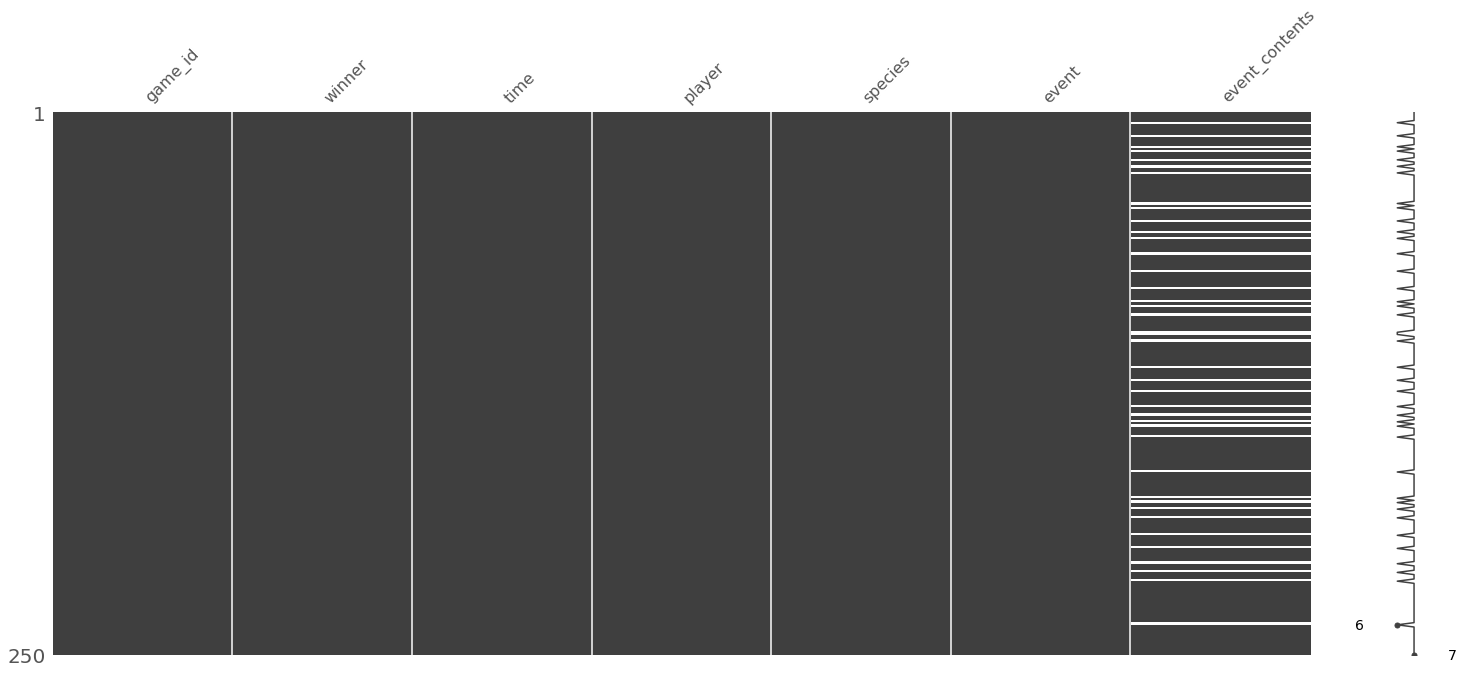

In [0]:
maso.matrix(train_data.sample(250))

In [0]:
train_data_sample = (train_data[train_data.game_id<=250])

species : 'Terran' : 0, 'Protoss' : 1, 'Zerg' : 2
event : 'Camera': 0, 'Selection': 1, 'Ability': 2, 'Right Click': 3, 'SetControlGroup': 4, 'GetControlGroup': 5, 'AddToControlGroup': 6, 'ControlGroup': 7


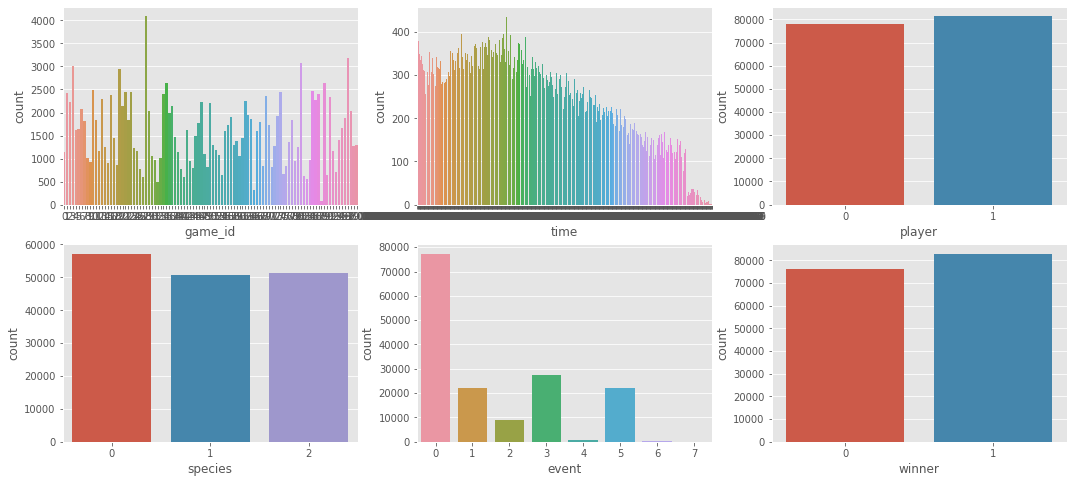

In [0]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.countplot(data=train_data_sample, x="game_id", ax=ax1)
sns.countplot(data=train_data_sample, x="time", ax=ax2)
sns.countplot(data=train_data_sample, x="player", ax=ax3)
sns.countplot(data=train_data_sample, x="species", ax=ax4)
sns.countplot(data=train_data_sample, x="event", ax=ax5)
sns.countplot(data=train_data_sample, x="winner", ax=ax6)
"""
ax1.set(title="game_id")
ax2.set(title="time")
ax3.set(title="player")
ax4.set(title="species")
ax5.set(title="event")
ax6.set(title="winner")
"""
print("species : 'Terran' : 0, 'Protoss' : 1, 'Zerg' : 2")
print("event : 'Camera': 0, 'Selection': 1, 'Ability': 2, 'Right Click': 3, 'SetControlGroup': 4, 'GetControlGroup': 5, 'AddToControlGroup': 6, 'ControlGroup': 7")


In [0]:
def each_species_winrate(train):
  df = train[['game_id', 'winner', 'player', 'species']]
  df = df.drop_duplicates().reset_index(drop=True)
  df['win'] = (df['winner'] == df['player'])
  df = df.drop(['winner'], axis=1)
  
  label = ['Terran', 'Protoss', 'Zerg']
  index = np.arange(len(label))  

  plt.bar(index, df['species'].value_counts())
  plt.xlabel('Species', fontsize=13)
  plt.ylabel('# of picks', fontsize=13)
  plt.xticks(index, label, fontsize=12)
  plt.show()

  game_ids = df['game_id'].unique()

  wins  = df.loc[df['win']==True]
  loses = df.loc[df['win']==False]

  game = {
    'TvT':0, 'TvP':0, 'TvZ':0,
    'PvT':0, 'PvP':0, 'PvZ':0,
    'ZvT':0, 'ZvP':0, 'ZvZ':0,
  }

  for game_id in game_ids:
      win  = wins[wins['game_id']==game_id]['species'].iloc[0]
      lose = loses[loses['game_id']==game_id]['species'].iloc[0]
    
      if (win == 0) and (lose == 0):
          game['TvT'] += 1
      elif (win == 0) and (lose == 1):
          game['TvP'] += 1
      elif (win == 0) and (lose == 2):
          game['TvZ'] += 1
        
      elif (win == 1) and (lose == 0):
          game['PvT'] += 1
      elif (win == 1) and (lose == 1):
          game['PvP'] += 1
      elif (win == 1) and (lose == 2):
          game['PvZ'] += 1
        
      elif (win == 2) and (lose == 0):
          game['ZvT'] += 1
      elif (win == 2) and (lose == 1):
          game['ZvP'] += 1
      elif (win == 2) and (lose == 2):
          game['ZvZ'] += 1
        
      else:
          raise ValueError

  print('테란 vs 프로토스')
  print('T: %.2f %%'%(100*game['TvP']/(game['TvP']+game['PvT'])))
  print('P: %.2f %% \n'%(100*game['PvT']/(game['TvP']+game['PvT'])))

  print('프로토스 vs 저그')
  print('P: %.2f %%'%(100*game['PvZ']/(game['PvZ']+game['ZvP'])))
  print('Z: %.2f %% \n'%(100*game['ZvP']/(game['PvZ']+game['ZvP'])))

  print('저그 vs 테란')
  print('Z: %.2f %%'%(100*game['ZvT']/(game['TvZ']+game['ZvT'])))
  print('T: %.2f %%'%(100*game['TvZ']/(game['TvZ']+game['ZvT'])))

In [0]:
#종족별 승률을 columns으로 만들어도 괜찮을듯?

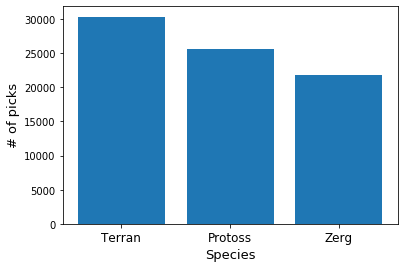

테란 vs 프로토스
T: 49.88 %
P: 50.12 % 

프로토스 vs 저그
P: 48.79 %
Z: 51.21 % 

저그 vs 테란
Z: 50.65 %
T: 49.35 %


In [0]:
each_species_winrate(train_data)

In [0]:
def plot_camera(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']==0]
    df_0 = df.loc[df['player']==0]
    df_1 = df.loc[df['player']==1]

    winner = df['winner'].iloc[0]
    game_time = df['time'].values[-1]
    player_0_species = df_0['species'].iloc[0]
    player_1_species = df_1['species'].iloc[0]

    player_0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_0['event_contents']]).astype(float)
    player_1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_1['event_contents']]).astype(float)
    
    plt.scatter(player_0_camera[:, 0], player_0_camera[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    plt.scatter(player_1_camera[:, 0], player_1_camera[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    plt.legend()
    plt.show()
    
    print('Total game time: %s'%(game_time))
    print('Winner: Player_%i'%(winner))
    print('Player_0: %s'%(player_0_species))
    print('Player_1: %s'%(player_1_species))
    #print(sns.pairplot(df_0))
    #print(sns.pairplot(df_1))

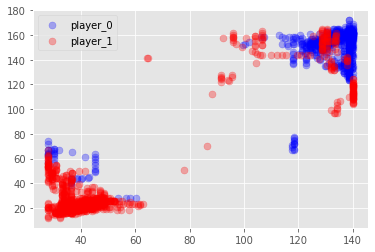

Total game time: 9.59
Winner: Player_1
Player_0: 1
Player_1: 0


In [0]:
plot_camera(train_data, 1)

In [0]:
zerg_unit = {'Rava' : 0, 'Drone' : 6, 'Overlord' : 1, 'Overseer' : 0, 'Viper' : 0, 'SwarmHost' : 0, 'Changeling' : 0, 'Zergling' : 0, 'Baneling' : 0, 'Queen' : 0, 'Hydralisk' : 0, 'Lurker' : 0, 'Roach' : 0, 'Mutalisk' : 0, 'Corruptor' : 0, 'BroodLord' : 0, 'Broodling' : 0, 'Infestor' : 0, 'InfestedTrrran' : 0, 'Ultralisk' : 0, 'NydusWorm' : 0}
zerg_building = {'Hatchery' : 1, 'Lair' : 0, 'Hive' : 0, 'Extractor' : 0, 'EvolutionChamber' : 0, 'SpawningPool' : 0, 'BanelingNest' : 0, 'RoachWarren' : 0, 'SpineCrawler' : 0, 'SporeCrawler' : 0, 'HydraliskDen' : 0, 'Spire' : 0, 'InfestationPit' : 0, 'NydusNetwork' : 0, 'GreaterSpire' : 0, 'UltraliskCavern' : 0, 'NydusCanal' : 0}
zerg_skill = {}

terran_unit = {'SCV' : 6, 'MULE' : 0, 'Nuke' : 0, 'Marine' : 0, 'Cyclone' : 0, 'Marauder' : 0, 'Reaper' : 0, 'Ghost' : 0, 'Hellion' : 0, 'BattleHellion' : 0, 'SiegeTank' : 0, 'Thor' : 0, 'Viking' : 0, 'Medivac' : 0, 'Banshee' : 0, 'Raven' : 0, 'AutoTurret' : 0, 'Battlecruiser' : 0, 'WidowMine' : 0, 'Liberator' : 0}
terran_building = {'CommandCenter' : 1, 'PlanetaryFortress' : 0, 'OrbitalCommand' : 0, 'SupplyDepot' : 0, 'Refinery' : 0, 'Barracks' : 0, 'BarracksTechLab' : 0, 'BarracksReactor' : 0, 'Bunker' : 0, 'EngineeringBay' : 0, 'MissileTurret' : 0, 'SensorTower' : 0, 'GhostAcademy' : 0, 'Factory' : 0,'FactoryTechLab' : 0,'FactoryReactor' : 0, 'Starport' : 0, 'StarportTechLab' : 0, 'StarportReactor' : 0,'Armory' : 0, 'FusionCore' : 0, 'TechLab' : 0, 'Reactor' : 0}
terran_skill = {}

protoss_unit = {'Probe' : 6, 'MothershipCore' : 0, 'Mothership' : 0, 'Zealot' : 0, 'Immortal' : 0, 'Stalker' : 0, 'Sentry' : 0, 'HighTemplar' : 0, 'DarkTemplar' : 0, 'Archon' : 0, 'Immertal' : 0, 'Observer' : 0, 'WarpPrism' : 0, 'Colossus' : 0, 'Disruptor' : 0, 'Phoenix' : 0, 'Carrier' : 0, 'VoidRay' : 0, 'Tempest' : 0, 'Oracle' : 0, 'Adept' : 0}
protoss_building = {'Nexus' : 1, 'Pylon' : 0, 'Assimilator' : 0, 'Gateway' : 0, 'WarpGate' : 0, 'Forge' : 0, 'CyberneticsCore' : 0, 'PhotonCannon' : 0, 'Stargate' : 0, 'TwilightCouncil' : 0, 'RoboticsFacility' : 0, 'RoboticsBay' : 0, 'DarkShrine' : 0, 'TemplarArchive' : 0, 'FleetBeacon' : 0}
protoss_skill = {}

In [0]:
zerg_unit_point = {'Rava' : 0, 'Drone' : 50, 'Overlord' : 100, 'Overseer' : 100, 'Viper' : 300, 'SwarmHost' : 175, 'Changeling' : 0, 'Zergling' : 50, 'Baneling' : 50, 'Queen' : 150, 'Hydralisk' : 150, 'Lurker' : 150, 'Roach' : 100, 'Mutalisk' : 200, 'Corruptor' : 250, 'BroodLord' : 300, 'Broodling' : 0, 'Infestor' : 250, 'InfestedTrrran' : 0, 'Ultralisk' : 500, 'NydusWorm' : 200}
zerg_building_point = {'Hatchery' : 300, 'Lair' : 250, 'Hive' : 350, 'Extractor' : 25, 'EvolutionChamber' : 75, 'SpawningPool' : 200, 'BanelingNest' : 150, 'RoachWarren' : 150, 'SpineCrawler' : 100, 'SporeCrawler' : 75, 'HydraliskDen' : 200, 'Spire' : 400, 'InfestationPit' : 200, 'NydusNetwork' : 350, 'GreaterSpire' : 250, 'UltraliskCavern' : 350, 'NydusCanal' : 350}
zerg_skill_point = {}

terran_unit_point = {'SCV' : 50, 'MULE' : 0, 'Nuke' : 0, 'Marine' : 50, 'Cyclone' : 250, 'Marauder' : 125, 'Reaper' : 100, 'Ghost' : 275, 'Hellion' : 100, 'BattleHellion' : 0 ,'SiegeTank' : 275, 'Thor' : 500, 'Viking' : 225, 'Medivac' : 200, 'Banshee' : 250, 'Raven' : 300, 'AutoTurret' : 0, 'Battlecruiser' : 700, 'WidowMine' : 100, 'Liberator' : 0}
terran_building_point = {'CommandCenter' : 400, 'PlanetaryFortress' : 200, 'OrbitalCommand' : 150, 'SupplyDepot' : 100, 'Refinery' : 75, 'Barracks' : 150, 'BarracksTechLab' : 100, 'BarracksReactor' : 75, 'Bunker' : 100, 'EngineeringBay' : 125, 'MissileTurret' : 100, 'SensorTower' : 225, 'GhostAcademy' : 200, 'Factory' : 250, 'FactoryTechLab' : 75, 'FactoryReactor' : 100, 'Starport' : 250, 'StarportTechLab' : 75, 'StarportReactor' : 100, 'Armory' : 250, 'FusionCore' : 300, 'TechLab' : 75, 'Reactor' : 100}
terran_skill_point = {}

protoss_unit_point = {'Probe' : 50, 'MothershipCore' : 200, 'Mothership' : 800, 'Zealot' : 100, 'Immortal' : 350, 'Stalker' : 175, 'Sentry' : 150, 'HighTemplar' : 200, 'DarkTemplar' : 250, 'Archon' : 0, 'Immertal' : 0, 'Observer' : 100, 'WarpPrism' : 200, 'Colossus' : 500, 'Disruptor' : 300, 'Phoenix' : 250, 'Carrier' : 600, 'VoidRay' : 400, 'Tempest' : 425, 'Oracle' : 300, 'Adept' : 125}
protoss_building_point = {'Nexus' : 400, 'Pylon' : 100, 'Assimilator' : 75, 'Gateway' : 150, 'WarpGate' : 0, 'Forge' : 150, 'CyberneticsCore' : 150, 'PhotonCannon' : 150, 'Stargate' : 300, 'TwilightCouncil' : 250, 'RoboticsFacility' : 300, 'RoboticsBay' : 400, 'DarkShrine' : 300, 'TemplarArchive' : 350, 'FleetBeacon' : 500}
protoss_skill_point = {}

In [0]:
# game_id 별 player 종족
def get_species(df, game_id):
  df = df.loc[df['game_id']==game_id]
  
  P0_species = df.loc[df['player']==0]
  P0_species = P0_species['species'].iloc[0]

  P1_species = df.loc[df['player']==1]
  P1_species = P1_species['species'].iloc[0]
  
  df = df.loc[df['event']==2]
  df_0 = df.loc[df['player']==0]
  df_1 = df.loc[df['player']==1]

  if P0_species == 0:
    P0_unit = terran_unit.copy()
    P0_building = terran_building.copy()
    P0_skill = terran_skill.copy()
    P0_unit_point = terran_unit_point.copy()
    P0_building_point = terran_building_point.copy()
    P0_skill_point = terran_skill_point.copy()
  elif P0_species == 1:
    P0_unit = protoss_unit.copy()
    P0_building = protoss_building.copy()
    P0_skill = protoss_skill.copy()
    P0_unit_point = protoss_unit_point.copy()
    P0_building_point = protoss_building_point.copy()
    P0_skill_point = protoss_skill_point.copy()
  elif P0_species == 2:
    P0_unit = zerg_unit.copy()
    P0_building = zerg_building.copy()
    P0_skill = zerg_skill.copy()
    P0_unit_point = zerg_unit_point.copy()
    P0_building_point = zerg_building_point.copy()
    P0_skill_point = zerg_skill_point.copy()
  
  if P1_species == 0:
    P1_unit = terran_unit.copy()
    P1_building = terran_building.copy()
    P1_skill = terran_skill.copy()
    P1_unit_point = terran_unit_point.copy()
    P1_building_point = terran_building_point.copy()
    P1_skill_point = terran_skill_point.copy()
  elif P1_species == 1:
    P1_unit = protoss_unit.copy()
    P1_building = protoss_building.copy()
    P1_skill = protoss_skill.copy()
    P1_unit_point = protoss_unit_point.copy()
    P1_building_point = protoss_building_point.copy()
    P1_skill_point = protoss_skill_point.copy()
  elif P1_species == 2:
    P1_unit = zerg_unit.copy()
    P1_building = zerg_building.copy()
    P1_skill = zerg_skill.copy()
    P1_unit_point = zerg_unit_point.copy()
    P1_building_point = zerg_building_point.copy()
    P1_skill_point = zerg_skill_point.copy()
  
  return [P0_unit, P0_building, P0_unit_point, P0_building_point, P1_unit, P1_building, P1_unit_point, P1_building_point]

In [0]:
# game_id 별 player의 event 추출
def get_event(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']==2]
    df_0 = df.loc[df['player']==0]
    df_1 = df.loc[df['player']==1]

    P0_contents = df_0['event_contents'].str.split()
    P0_contents = P0_contents.apply(lambda x: pd.Series(x))
    try:
      a = P0_contents[2]
    except IndexError: a = pd.Series(['null'])
    a.fillna('null', inplace = True)
    a = a.to_list()
    
    for i in range(len(a)):
      aparse = re.sub('[-=.#/?:$};]', '', a[i])
      a[i] = aparse
    
    P1_contents = df_1['event_contents'].str.split()
    P1_contents = P1_contents.apply(lambda x: pd.Series(x))
      
    try:  
      b = P1_contents[2]
    except IndexError: b = pd.Series(['null'])
    b.fillna('null', inplace = True)
    b = b.to_list()

    for i in range(len(b)):
      bparse = re.sub('[-=.#/?:$};]', '', b[i])
      b[i] = bparse

    return [a,b]

In [0]:
# game_id 별 player unit 생산량
def get_number_of_unit(df, game_id):
  P = get_species(df, game_id)
  P0_unit = P[0]
  P0_unit_point = P[2]
  P1_unit = P[4]
  P1_unit_point = P[6]
  c = get_event(df ,game_id)
  a = c[0]
  b = c[1]

  for i in range(len(a)):
      aparse = re.sub('[-=.#/?:$};]', '', a[i])
      a[i] = aparse
      if a[i] == 'BuildSiegeTank':
        a[i] = 'TrainSiegeTank'
      if a[i] == 'BuildWidowMine':
        a[i] = 'TrainWidowMine'
      if a[i] == 'MorphToOverseer':
        a[i] = 'MorphOverseer'
      if a[i] == 'CalldwonMULE':
        a[i] = 'TrainMULE'
      if a[i] == 'MorphToRavager':
        a[i] = 'MorphRava'
      if a[i] == 'MorphToTransportOverlord':
        a[i] = 'ToTransportOverlord'
      if a[i] == 'MorphToGreaterSpire':
        a[i] = 'BuildGreaterSpire'
      if a[i] == 'MorphToBroodLord':
        a[i] = 'MorphBroodLord'
      if a[i] == 'MorphToLurker':
        a[i] = 'MorphLurker'
      if a[i] == 'TrainInterceptor':
        a[i] = 'Interceptor'
      if a[i] == 'BuildAutoTurret':
        a[i] = 'TrainAutoTurret'
      if a[i] == 'BuildThor':
        a[i] = 'TrainThor'
      if a[i] == 'BuildBattleHellion':
        a[i] = 'TrainBattleHellion'
      if a[i] == 'BuildPointDefenseDrone':
        a[i] = 'PointDefenseDrone'

  for i in range(len(a)):
    if 'Train' in a[i] or 'Morph' in a[i] and 'Cancel' not in a[i]:
      c = a[i]
      P0_unit[c[5:]] += 1
      #P0_total += 1
  
    elif  'Build' not in a[i] and 'Cancel' in a[i]:
      c = a[i]
      p = c[6:]
      if p in P0_unit:
        P0_unit[p] -= 1
        #P0_total -= 1    

  for i in range(len(b)):
      bparse = re.sub('[-=.#/?:$};]', '', b[i])
      b[i] = bparse
      if b[i] == 'BuildSiegeTank':
        b[i] = 'TrainSiegeTank'
      if b[i] == 'BuildWidowMine':
        b[i] = 'TrainWidowMine'
      if b[i] == 'MorphToOverseer':
        b[i] = 'MorphOverseer'
      if b[i] == 'CalldwonMULE':
        b[i] = 'TrainMULE'
      if b[i] == 'MorphToRavager':
        b[i] = 'MorphRava'
      if b[i] == 'MorphToTransportOverlord':
        b[i] = 'ToTransportOverlord'
      if b[i] == 'MorphToGreaterSpire':
        b[i] = 'BuildGreaterSpire'
      if b[i] == 'MorphToBroodLord':
        b[i] = 'MorphBroodLord'
      if b[i] == 'MorphToLurker':
        b[i] = 'MorphLurker'
      if b[i] == 'TrainInterceptor':
        b[i] = 'Interceptor'
      if b[i] == 'BuildAutoTurret':
        b[i] = 'TrainAutoTurret'
      if b[i] == 'BuildThor':
        b[i] = 'TrainThor'
      if b[i] == 'BuildBattleHellion':
        b[i] = 'TrainBattleHellion'
      if b[i] == 'BuildPointDefenseDrone':
        b[i] = 'PointDefenseDrone'


  for i in range(len(b)):
    if 'Train' in b[i] or 'Morph' in b[i] and 'Cancel' not in b[i]:
      d = b[i]
      P1_unit[d[5:]] += 1
      #P1_total += 1
  
    elif 'Build' not in b[i] and 'Cancel' in b[i]:
      d = b[i]
      q = d[6:]
      if q in P1_unit:
        P1_unit[q] -= 1
        #P1_total -= 1    

  return [P0_unit, P1_unit, P0_unit_point, P1_unit_point]

In [0]:
# 유닛 총 생산 점수
def get_unit_point(df, game_id):
    ga = get_event(df, game_id)
    gb = get_number_of_unit(df, game_id)

    P0_unit = gb[0]
    P0_unit_point = gb[2]
    P0_unit = list(P0_unit.values())
    P0_unit_point = list(P0_unit_point.values())

    P1_unit = gb[1]
    P1_unit_point = gb[3]
    P1_unit = list(P1_unit.values())
    P1_unit_point = list(P1_unit_point.values())

    P0_count = 0
    for i in range(len(P0_unit)):
      P0_count += P0_unit[i] * P0_unit_point[i]
    
    P1_count = 0
    for j in range(len(P1_unit)):
      P1_count += P1_unit[j] * P1_unit_point[j]
    
    return [P0_count, P1_count]

In [0]:
# 유닛 생산량 7등분
def get_unit_point_split(df, game_id):
    ga = get_event(df, game_id)
    gb = get_number_of_unit(df, game_id)

    P0_unit = gb[0]
    P0_unit_point = gb[2]
    P0_unit = list(P0_unit.values())
    P0_unit_point = list(P0_unit_point.values())

    P1_unit = gb[1]
    P1_unit_point = gb[3]
    P1_unit = list(P1_unit.values())
    P1_unit_point = list(P1_unit_point.values())

    P0_count = 0
    P0_10 = []
    P0_divide = round(len(P0_unit) / 7)
    for i in range(len(P0_unit)):
      P0_count += P0_unit[i] * P0_unit_point[i]
      if i % P0_divide == 0:
        P0_10.append(P0_count)

    P1_count = 0
    P1_10 = []
    P1_divide = round(len(P1_unit) / 7)
    for j in range(len(P1_unit)):
      P1_count += P1_unit[j] * P1_unit_point[j]
      if j % P1_divide == 0:
        P1_10.append(P1_count)
    
    return [P0_10, P1_10]

In [0]:
get_unit_point_split(train_data , 0)

[[750, 900, 900, 900, 900, 1100, 1200], [600, 850, 850, 850, 1400, 1400, 1400]]

In [0]:
def get_number_of_building(df, game_id):
  P = get_species(df, game_id)
  P0_building = P[1]
  P0_building_point = P[3]
  P1_building = P[5]
  P1_building_point = P[7]
  c = get_event(df ,game_id)
  a = c[0]
  b = c[1]

  for i in range(len(a)):
      aparse = re.sub('[-=.#/?:$};]', '', a[i])
      a[i] = aparse
      if a[i] == 'BuildSiegeTank':
        a[i] = 'TrainSiegeTank'
      if a[i] == 'BuildWidowMine':
        a[i] = 'TrainWidowMine'
      if a[i] == 'BuildHellion':
        a[i] = 'TrainHellion'
      if a[i] == 'BuildCreepTumor':
        a[i] = 'CreepTumor'
      if a[i] == 'BuildOracleStasisTrap':
        a[i] = 'OracleStasisTrap'
      if a[i] == 'BuildAutoTurret':
        a[i] = 'TrainAutoTurret'
      if a[i] == 'BuildThor':
        a[i] = 'TrainThor'
      if a[i] == 'BuildBattleHellion':
        a[i] = 'TrainBattleHellion'
      if a[i] == 'BuildPointDefenseDrone':
        a[i] = 'PointDefenseDrone'

  for i in range(len(a)):
    if 'Build' in a[i] and 'Cancel' not in a[i] and 'Halt' not in a[i]:
      c = a[i]
      P0_building[c[5:]] += 1

    elif  'Build' not in a[i] and 'Cancel' in a[i]:
      c = a[i]
      p = c[6:]
      if p in P0_building:
        P0_building[p] -= 1

  for i in range(len(b)):
      bparse = re.sub('[-=.#/?:$};]', '', b[i])
      b[i] = bparse
      if b[i] == 'BuildSiegeTank':
        b[i] = 'TrainSiegeTank'
      if b[i] == 'BuildWidowMine':
        b[i] = 'TrainWidowMine'
      if b[i] == 'BuildHellion':
        b[i] = 'TrainHellion'
      if b[i] == 'BuildCreepTumor':
        b[i] = 'CreepTumor'
      if b[i] == 'BuildOracleStasisTrap':
        b[i] = 'OracleStasisTrap'
      if b[i] == 'BuildAutoTurret':
        b[i] = 'TrainAutoTurret'
      if b[i] == 'BuildThor':
        b[i] = 'TrainThor'
      if b[i] == 'BuildBattleHellion':
        b[i] = 'TrainBattleHellion'
      if b[i] == 'BuildPointDefenseDrone':
        b[i] = 'PointDefenseDrone'

  for i in range(len(b)):
    if 'Build' in b[i] and 'Cancel' not in b[i] and 'Halt' not in b[i]:
      c = b[i]
      P1_building[c[5:]] += 1
  
    elif  'Build' not in b[i] and 'Cancel' in b[i]:
      c = b[i]
      p = c[6:]
      if p in P1_building:
        P1_building[p] -= 1

  return [P0_building, P1_building, P0_building_point, P1_building_point]

In [0]:
get_number_of_building(train_data,200)

In [0]:
def get_building_point(df, game_id):
    ga = get_event(df, game_id)
    gb = get_number_of_building(df, game_id)

    P0_building = gb[0]
    P0_building_point = gb[2]
    P0_building = list(P0_building.values())
    P0_building_point = list(P0_building_point.values())

    P1_building = gb[1]
    P1_building_point = gb[3]
    P1_building = list(P1_building.values())
    P1_building_point = list(P1_building_point.values())

    P0_count = 0
    for i in range(len(P0_building)):
      P0_count += P0_building[i] * P0_building_point[i]
    
    P1_count = 0
    for j in range(len(P1_building)):
      P1_count += P1_building[j] * P1_building_point[j]
    
    return [P0_count, P1_count]

In [0]:
def get_building_point_split(df, game_id):
    ga = get_event(df, game_id)
    gb = get_number_of_building(df, game_id)

    P0_building = gb[0]
    P0_building_point = gb[2]
    P0_building = list(P0_building.values())
    P0_building_point = list(P0_building_point.values())

    P1_building = gb[1]
    P1_building_point = gb[3]
    P1_building = list(P1_building.values())
    P1_building_point = list(P1_building_point.values())

    P0_count = 0
    P0_10 = []
    P0_divide = round(len(P0_building) / 7)
    for i in range(len(P0_building)):
      P0_count += P0_building[i] * P0_building_point[i]
      if i % P0_divide == 0:
        P0_10.append(P0_count)
    
    P1_count = 0
    P1_10 = []
    P1_divide = round(len(P1_building) / 7)
    for j in range(len(P1_building)):
      P1_count += P1_building[j] * P1_building_point[j]
      if j % P1_divide == 0:
        P1_10.append(P1_count)
    
    return [P0_10, P1_10]

In [0]:
get_building_point_split(train_data, 0)

[[800, 1200, 1650, 1850, 1850, 2175, 2425, 2425],
 [400, 700, 1100, 1100, 1100, 1425, 1425, 1425]]

In [0]:
# 모든 경기 유닛,건물 총 점수
def get_total_point(df):
    game_ids = len(df['game_id'].unique())
    P0_total_unit_point = []
    get_building_point_split = []
    P1_total_unit_point = []
    P1_total_building_point = []

    try:
      for i in range(38872, game_ids  + 38872):
        unit_point = get_unit_point(df,i)
        building_point = get_building_point(df,i)
        
        P0_total_unit_point.append(unit_point[0])
        P1_total_unit_point.append(unit_point[1])
        P0_total_building_point.append(building_point[0])
        P1_total_building_point.append(building_point[1])
    except:return [P0_total_unit_point, P0_total_building_point, P1_total_unit_point, P1_total_building_point, i]
    
    return [P0_total_unit_point, P0_total_building_point, P1_total_unit_point, P1_total_building_point, i]

In [0]:
# 유닛,건물 분할 계산
def get_total_point_split(df):
    game_ids = len(df['game_id'].unique())
    P0_total_unit_point = []
    P0_total_building_point = []
    P1_total_unit_point = []
    P1_total_building_point = []

    try:
      for i in range(38872, game_ids  + 38872):
        unit_point = get_unit_point_split(df,i)
        building_point = get_building_point_split(df,i)
        
        P0_total_unit_point.append(unit_point[0])
        P1_total_unit_point.append(unit_point[1])
        P0_total_building_point.append(building_point[0])
        P1_total_building_point.append(building_point[1])
    except:return [P0_total_unit_point, P0_total_building_point, P1_total_unit_point, P1_total_building_point, i]
    
    return [P0_total_unit_point, P0_total_building_point, P1_total_unit_point, P1_total_building_point]

In [0]:
def get_species_winrate(df, game_id):
  df = df.loc[df['game_id']==game_id]
  
  P0_species = df.loc[df['player']==0]
  P0_species = P0_species['species'].iloc[0]

  P1_species = df.loc[df['player']==1]
  P1_species = P1_species['species'].iloc[0]
  
  df = df.loc[df['event']==2]
  df_0 = df.loc[df['player']==0]
  df_1 = df.loc[df['player']==1]

  
  if P0_species == P1_species:
    P0_winrate = 50
    P1_winrate = 50
  elif P0_species == 0 and P1_species == 1:
    P0_winrate = 49.88
    P1_winrate = 50.12
  elif P0_species == 1 and P1_species == 0:
    P0_winrate = 50.12
    P1_winrate = 49.88
  elif P0_species == 0 and P1_species == 2:
    P0_winrate = 49.35
    P1_winrate = 50.65
  elif P0_species == 2 and P1_species == 0:
    P0_winrate = 50.65
    P1_winrate = 49.35
  elif P0_species == 1 and P1_species == 2:
    P0_winrate = 48.79
    P1_winrate = 51.21
  elif P0_species == 2 and P1_species == 1:
    P0_winrate = 51.21
    P1_winrate = 48.79

  return [P0_winrate, P1_winrate]

In [0]:
def get_total_species_winrate(df):
  game_ids = len(df['game_id'].unique())
  P0_total_winrate = []
  P1_total_winrate = []

  for i in range(game_ids):
    c = get_species_winrate(df, i)
    P0_total_winrate.append(c[0])
    P1_total_winrate.append(c[1])
  
  return P0_total_winrate, P1_total_winrate

In [0]:
c = get_total_species_winrate(train_data)

In [0]:
print(len(c[0]))

In [0]:
# dataframe으로 변환뒤 합치기

In [0]:
a = get_total_point_split(train_data)

In [0]:
a

In [0]:
P0_unit_split = a[0]
P0_building_split = a[1]
P1_unit_split = a[2]
P1_building_split = a[3]

In [0]:
P0_unit_df = pd.DataFrame(P0_unit_split, columns =['P0_unit_t1', 'P0_unit_t2', 'P0_unit_t3', 'P0_unit_t4', 'P0_unit_t5', 'P0_unit_t6', 'P0_unit_t7',],dtype = int)
P0_building_df = pd.DataFrame(P0_building_split, columns =['P0_building_t1', 'P0_building_t2', 'P0_building_t3', 'P0_building_t4', 'P0_building_t5', 'P0_building_t6', 'P0_building_t7', 'P0_building_t8', 'P0_building_t9'],dtype = int)
P1_unit_df = pd.DataFrame(P1_unit_split, columns =['P1_unit_t1', 'P1_unit_t2', 'P1_unit_t3', 'P1_unit_t4', 'P1_unit_t5', 'P1_unit_t6', 'P1_unit_t7',],dtype = int)
P1_building_df = pd.DataFrame(P1_building_split, columns =['P1_building_t1', 'P1_building_t2', 'P1_building_t3', 'P1_building_t4', 'P1_building_t5', 'P1_building_t6', 'P1_building_t7', 'P1_building_t8', 'P1_building_t9'],dtype = int)

In [0]:
P0_building_df = P0_building_df.drop(columns=['P0_building_t8','P0_building_t9'])
P1_building_df = P1_building_df.drop(columns=['P1_building_t8','P1_building_t9'])

In [0]:
b = get_total_point_split(test_data)

In [0]:
P0t_unit_split = b[0]
P0t_building_split = b[1]
P1t_unit_split = b[2]
P1t_building_split = b[3]

In [0]:
P0t_unit_df = pd.DataFrame(P0t_unit_split, columns =['P0_unit_t1', 'P0_unit_t2', 'P0_unit_t3', 'P0_unit_t4', 'P0_unit_t5', 'P0_unit_t6', 'P0_unit_t7',],dtype = int)
P0t_building_df = pd.DataFrame(P0t_building_split, columns =['P0_building_t1', 'P0_building_t2', 'P0_building_t3', 'P0_building_t4', 'P0_building_t5', 'P0_building_t6', 'P0_building_t7', 'P0_building_t8', 'P0_building_t9'],dtype = int)
P1t_unit_df = pd.DataFrame(P1t_unit_split, columns =['P1_unit_t1', 'P1_unit_t2', 'P1_unit_t3', 'P1_unit_t4', 'P1_unit_t5', 'P1_unit_t6', 'P1_unit_t7',],dtype = int)
P1t_building_df = pd.DataFrame(P1t_building_split, columns =['P1_building_t1', 'P1_building_t2', 'P1_building_t3', 'P1_building_t4', 'P1_building_t5', 'P1_building_t6', 'P1_building_t7', 'P1_building_t8', 'P1_building_t9'],dtype = int)

In [0]:
P0t_building_df = P0t_building_df.drop(columns=['P0_building_t8','P0_building_t9'])
P1t_building_df = P1t_building_df.drop(columns=['P1_building_t8','P1_building_t9'])

In [0]:
P1t_building_df

,P1_building_t1,P1_building_t2,P1_building_t3,P1_building_t4,P1_building_t5,P1_building_t6,P1_building_t7
0,800,1450,1600,1750,2500,2500,2500
1,800,1200,1500,1800,1950,2200,2200
2,400,700,850,850,850,850,1100
3,800,1200,1800,1950,1950,2200,2200
4,300,300,350,550,550,550,550
...,...,...,...,...,...,...,...
16782,800,1000,1300,1375,1375,1625,1625
16783,800,1300,1900,2100,2100,2350,2600
16784,400,1550,1700,1850,2600,2600,2600
16785,400,500,725,725,725,725,725


In [0]:
#여기부터 미완

In [0]:
def map_and_starting(train):
  df_train = pd.DataFrame(train.game_id.unique(), columns=['game_id'])
  
  df_train_p0 = train[(train.event==0)&(train.player==0)]
  df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
  df_train_p0 = df_train_p0.iloc[:, [0,6]].rename({'event_contents':'player0_starting'}, axis = 1)
  df_train_p0.index = df_train_p0['game_id']
  df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
  df_train = pd.merge(df_train, df_train_p0, on='game_id', how='left')
  del df_train_p0

  df_train_p1 = train[(train.event==0)&(train.player==1)]
  df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
  df_train_p1 = df_train_p1.iloc[:, [0,6]].rename({'event_contents':'player1_starting'}, axis = 1)
  df_train_p1.index = df_train_p1['game_id']
  df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
  df_train = pd.merge(df_train, df_train_p1, on='game_id', how='left')
  del df_train_p1

  df_train['player0_starting'] = df_train.player0_starting.str.split('(').str[1]
  df_train['player0_starting'] = df_train.player0_starting.str.split(')').str[0]
  split_xy = df_train.player0_starting.str.split(',')
  df_train['player0_x'] = split_xy.str[0].astype('float')
  df_train['player0_y'] = split_xy.str[1].astype('float')
  del split_xy

  df_train['player1_starting'] = df_train.player1_starting.str.split('(').str[1]
  df_train['player1_starting'] = df_train.player1_starting.str.split(')').str[0]
  split_xy = df_train.player1_starting.str.split(',')
  df_train['player1_x'] = split_xy.str[0].astype('float')
  df_train['player1_y'] = split_xy.str[1].astype('float')
  del split_xy
  df_train = df_train.set_index('game_id')
  location_p0 = df_train.loc[:, ['player0_x', 'player0_y']]
  location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

  location_p1 = df_train.loc[:, ['player1_x', 'player1_y']]
  location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
  location_p1.index += location_p0.index[-1]+1

  location = pd.concat([location_p0, location_p1])
  location = location.dropna()
  del location_p0, location_p1
  
  kmeans_clst = KMeans(n_clusters=15).fit(location)
  location['starting'] = kmeans_clst.labels_+1

  for cluster in range(15):
    point = location[location.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location.loc[loc.index, 'distance'] = distance
    del loc
  
  idx = location[location.distance>5].index
  location.loc[idx, 'starting'] = 0
  del idx

  df_train['player0_starting'] = location.loc[df_train.index, 'starting']
  location.index -= (df_train.index[-1]+1)
  df_train['player1_starting'] = location.loc[df_train.index, 'starting']
  del location

  # 불필요한 컬럼 삭제
  df_train = df_train.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
  df_train = df_train.fillna(0)

  map_list = []
  for point in range(1,16):
    couple = df_train[df_train.player0_starting == point].player1_starting.value_counts()
    if couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
  map_list = np.sort(map_list, axis = 1)
  map_list = np.unique(map_list, axis = 0)

  for m in map_list:
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[0])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[1])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[0])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[1])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[0]
    del idx
  df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)].head()

  for map_num, m in enumerate(map_list):
    idx = df_train[(df_train.player0_starting == m[0])|(df_train.player0_starting == m[1])|(df_train.player0_starting == m[2])].index
    df_train.loc[idx, 'map'] = map_num
  del idx, map_list
  print(df_train)

  return df_train

In [0]:
d = map_and_starting(train_data)

         player0_starting  player1_starting  map
game_id                                         
0                     7.0               9.0  5.0
1                    10.0              15.0  6.0
2                    14.0               2.0  1.0
3                     5.0              13.0  3.0
4                    11.0               1.0  0.0
...                   ...               ...  ...
38867                 9.0               7.0  5.0
38868                15.0              10.0  6.0
38869                14.0               2.0  1.0
38870                 3.0               4.0  2.0
38871                 1.0              11.0  0.0

[38872 rows x 3 columns]


In [0]:
def get_total_event(df):
    df = df.loc[df['event']==2]
    df = df['event_contents'].str.split()
    df = df.apply(lambda x: pd.Series(x))
    df = df[2]
    df.fillna('notexistevent', inplace=True)
    df = df.to_list()
    for i in range(len(df)):
        parse = re.sub('[-=.#/?:$};]', '', df[i])
        df[i] = parse
    uniqueevent = sorted(list(set(df)))
    
    return uniqueevent

In [0]:
total_event = get_event(train_data)

In [0]:
# 모델에 학습시킬 데이터 준비
def data_preparation(df, answer=False):
    game_ids = df['game_id'].unique()
    events = ['0','1','2','3','4','5','6','7']
    unique_event_0, unique_event_1, delta_event = {}, {}, {}
    for event in events:
        unique_event_0['P0_' + event] = 0
        unique_event_1['P1_' + event] = 0
        #delta_event['delta_' + event] = 0
        
    species = df.groupby(['game_id', 'player']).species.unique()
    event_count = df.groupby(['game_id', 'player']).event.value_counts()
    if answer:
        winners = df.groupby(['game_id']).winner.max()
    
    x_data, y_data = [], []
    for game_id in tqdm(game_ids):
        count = 0
        df_event_count = event_count[game_id].unstack(level=-1)
        df = pd.DataFrame(species[game_id])
        df = pd.concat([df, df_event_count], axis=1)   
        df = df.fillna(0)
        
        df_P0_species = pd.DataFrame([df.loc[0]['species'][0]], columns=['P0_species'])        
        df_P1_species = pd.DataFrame([df.loc[1]['species'][0]], columns=['P1_species'])
        df = df.drop(['species'], axis=1)

        df_P0_event = unique_event_0.copy()
        for column in df.columns:
            df_P0_event['P0_' + str(column)] = df.loc[0][column]
        df_P0_event = pd.DataFrame(pd.Series(df_P0_event)).T

        df_P1_event = unique_event_1.copy()
        for column in df.columns:
            df_P1_event['P1_' + str(column)] = df.loc[1][column]
        df_P1_event = pd.DataFrame(pd.Series(df_P1_event)).T
        """
        df_delta_event = delta_event.copy()
        for column in df.columns:
            df_delta_event['delta_' + str(column)] = df_P0_event['P0_' + str(column)][0] - df_P1_event['P1_' + str(column)][0]
        df_delta_event = pd.DataFrame(pd.Series(df_delta_event)).T
        """
        out = pd.concat([df_P0_species, df_P0_event, df_P1_species, df_P1_event], axis=1) #, df_delta_event
        out.index = [game_id]
        out.index.name = 'game_id'
        
        x_data.append(out)
        if answer:
            y_data.append(winners[game_id])  

    x_data = pd.concat(x_data)
    y_data = np.array(y_data)
    
    return x_data, y_data

In [0]:
x_train, y_train = data_preparation(train_data, answer=True)

100%|██████████| 38872/38872 [05:20<00:00, 121.21it/s]


In [0]:
x_train["P0_total_unit_point"] = P0_total_unit_point
x_train["P0_total_building_point"] = P0_total_building_point
x_train["P1_total_unit_point"] = P1_total_unit_point
x_train["P1_total_building_point"] = P1_total_building_point

In [0]:
x_train.isnull().sum()

P0_species    0
P0_0          0
P0_1          0
P0_2          0
P0_3          0
P0_4          0
P0_5          0
P0_6          0
P0_7          0
P1_species    0
P1_0          0
P1_1          0
P1_2          0
P1_3          0
P1_4          0
P1_5          0
P1_6          0
P1_7          0
dtype: int64

In [0]:
x_train = pd.merge(x_train, P0_unit_df, left_index=True, right_index=True)

In [0]:
x_train = pd.merge(x_train, P0_building_df, left_index=True, right_index=True)

In [0]:
x_train = pd.merge(x_train, P1_unit_df, left_index=True, right_index=True)

In [0]:
x_train = pd.merge(x_train, P1_building_df, left_index=True, right_index=True)

In [0]:
x_train

,P0_species,P0_0,P0_1,P0_2,P0_3,P0_4,P0_5,P0_6,P0_7,P1_species,P1_0,P1_1,P1_2,P1_3,P1_4,P1_5,P1_6,P1_7,P0_unit_t1,P0_unit_t2,P0_unit_t3,P0_unit_t4,P0_unit_t5,P0_unit_t6,P0_unit_t7,P0_building_t1,P0_building_t2,P0_building_t3,P0_building_t4,P0_building_t5,P0_building_t6,P0_building_t7,P0_building_t8,P0_building_t9,P1_unit_t1,P1_unit_t2,P1_unit_t3,P1_unit_t4,P1_unit_t5,P1_unit_t6,P1_unit_t7,P1_building_t1,P1_building_t2,P1_building_t3,P1_building_t4,P1_building_t5,P1_building_t6,P1_building_t7,P1_building_t8,P1_building_t9
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,444.0,50.0,34.0,35.0,3.0,24.0,2.0,0.0,0,425.0,57.0,34.0,28.0,1.0,3.0,0.0,0.0,750,900,900,900,900,1100,1200,800,1200,1650,1850,1850,2175,2425,2425,NaN,600,850,850,850,1400,1400,1400,400,700,1100,1100,1100,1425,1425,1425,NaN
1,1,627.0,186.0,77.0,160.0,10.0,162.0,1.0,0.0,0,858.0,116.0,67.0,131.0,8.0,31.0,0.0,0.0,1400,1600,1600,1600,1900,2700,2700,800,1825,2575,2875,2875,3675,4075,4075,NaN,1150,1450,1550,1550,2375,2575,2675,1200,1400,2000,2150,2450,2700,3025,3025,NaN
2,1,413.0,90.0,69.0,160.0,14.0,99.0,6.0,0.0,2,725.0,232.0,85.0,204.0,9.0,109.0,5.0,2.0,1250,1450,1625,1625,1625,1625,2025,800,1750,2050,2200,2500,2800,3200,3700,NaN,0,2250,2250,2900,3200,3200,3200,900,900,1050,1250,1400,1750,1750,1750,1750.0
3,0,713.0,180.0,82.0,276.0,6.0,132.0,0.0,0.0,1,388.0,148.0,89.0,268.0,19.0,710.0,0.0,0.0,650,1100,1700,1700,1975,2575,2675,1200,1800,2325,2675,2675,2925,3175,3175,NaN,1500,1700,2225,2225,2525,2525,2525,800,1800,2400,2550,2550,3100,3100,3450,NaN
4,0,430.0,67.0,57.0,177.0,10.0,224.0,1.0,0.0,2,272.0,126.0,36.0,106.0,8.0,99.0,4.0,0.0,1000,1150,1150,1150,1150,1400,1400,800,1000,1400,1475,1475,1725,1725,1725,NaN,0,1450,1450,1800,1800,1800,1800,600,600,625,825,975,975,975,975,975.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,0,639.0,53.0,43.0,95.0,1.0,0.0,0.0,0.0,1,324.0,58.0,32.0,43.0,0.0,0.0,0.0,0.0,850,1000,1000,1000,1000,1000,1000,800,1000,1450,1575,1675,2100,2350,2350,NaN,600,900,900,900,900,900,1700,800,1450,1450,1600,1900,2150,2150,2150,NaN
38868,0,558.0,62.0,63.0,123.0,0.0,0.0,0.0,0.0,1,633.0,48.0,28.0,56.0,3.0,8.0,0.0,0.0,650,1050,1550,1825,2100,2100,2100,800,1100,1500,1900,2500,2825,2825,2825,NaN,850,1150,1325,1325,1325,1325,1325,800,975,1125,1425,1725,1725,1725,2225,NaN
38869,1,785.0,106.0,56.0,248.0,4.0,28.0,0.0,0.0,2,330.0,191.0,53.0,167.0,6.0,89.0,2.0,0.0,1150,1150,1325,1325,1325,1575,1575,800,1500,1950,2100,2700,2700,2700,2700,NaN,0,1550,1550,2300,2300,2300,2300,600,600,625,775,775,850,850,850,850.0


In [0]:
x_train = pd.read_csv('/content/drive/My Drive/data/dacon게임분석대회/x_train.csv', index_col='game_id')

In [0]:
x_train = x_train.drop(columns=['P0_building_t8', 'P0_building_t8', 'P1_building_t8', 'P1_building_t9'], axis=1)

In [0]:
x_train = pd.merge(x_train, d, left_index=True, right_index=True)

In [0]:
x_train.head()

,P0_species,P0_0,P0_1,P0_2,P0_3,P0_4,P0_5,P0_6,P0_7,P1_species,P1_0,P1_1,P1_2,P1_3,P1_4,P1_5,P1_6,P1_7,P0_unit_t1,P0_unit_t2,P0_unit_t3,P0_unit_t4,P0_unit_t5,P0_unit_t6,P0_unit_t7,P0_building_t1,P0_building_t2,P0_building_t3,P0_building_t4,P0_building_t5,P0_building_t6,P0_building_t7,P0_building_t9,P1_unit_t1,P1_unit_t2,P1_unit_t3,P1_unit_t4,P1_unit_t5,P1_unit_t6,P1_unit_t7,P1_building_t1,P1_building_t2,P1_building_t3,P1_building_t4,P1_building_t5,P1_building_t6,P1_building_t7,player0_starting,player1_starting,map
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,444.0,50.0,34.0,35.0,3.0,24.0,2.0,0.0,0,425.0,57.0,34.0,28.0,1.0,3.0,0.0,0.0,750,900,900,900,900,1100,1200,800,1200,1650,1850,1850,2175,2425,NaN,600,850,850,850,1400,1400,1400,400,700,1100,1100,1100,1425,1425,7.0,9.0,5.0
1,1,627.0,186.0,77.0,160.0,10.0,162.0,1.0,0.0,0,858.0,116.0,67.0,131.0,8.0,31.0,0.0,0.0,1400,1600,1600,1600,1900,2700,2700,800,1825,2575,2875,2875,3675,4075,NaN,1150,1450,1550,1550,2375,2575,2675,1200,1400,2000,2150,2450,2700,3025,10.0,15.0,6.0
2,1,413.0,90.0,69.0,160.0,14.0,99.0,6.0,0.0,2,725.0,232.0,85.0,204.0,9.0,109.0,5.0,2.0,1250,1450,1625,1625,1625,1625,2025,800,1750,2050,2200,2500,2800,3200,NaN,0,2250,2250,2900,3200,3200,3200,900,900,1050,1250,1400,1750,1750,14.0,2.0,1.0
3,0,713.0,180.0,82.0,276.0,6.0,132.0,0.0,0.0,1,388.0,148.0,89.0,268.0,19.0,710.0,0.0,0.0,650,1100,1700,1700,1975,2575,2675,1200,1800,2325,2675,2675,2925,3175,NaN,1500,1700,2225,2225,2525,2525,2525,800,1800,2400,2550,2550,3100,3100,5.0,13.0,3.0
4,0,430.0,67.0,57.0,177.0,10.0,224.0,1.0,0.0,2,272.0,126.0,36.0,106.0,8.0,99.0,4.0,0.0,1000,1150,1150,1150,1150,1400,1400,800,1000,1400,1475,1475,1725,1725,NaN,0,1450,1450,1800,1800,1800,1800,600,600,625,825,975,975,975,11.0,1.0,0.0


In [0]:
x_train.to_csv('x_train.csv', header='game_id')

In [0]:
# 모델 및 파라미터 정의
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [0]:
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=4321                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=30) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화

# 이 예제에서는 7개 하이퍼 파라미터에 대해 30회 조정을 시도했습니다.
# 다양한 하이퍼 파라미터, 더 많은 iteration을 시도하여 최상의 모델을 얻어보세요!
# LightGBM Classifier: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6499   |  0.0708   |  0.08152  |  790.0    |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.6701   |  0.7578   |  0.009006 |  328.4    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.6657   |  0.6787   |  0.09504  |  299.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.6612   |  0.9299   |  0.09484  |  394.5    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.6729   |  0.4301   |  0.007886 |  788.7    |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.6595   |  0.504    |  0.03846  |  22.88    |  1.004e+0 |  3.029    |  3.111    |  0.4958   |
|  7        |  0.6627   |  0.5582   |  0.09611  |  502.7    |  994.7    |  9.715    |  1.905    |  0.2101   |
|  8      

KeyboardInterrupt: ignored

In [0]:
# 최댓값들만 추출
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
#    params['min_child_samples'], 
#    params['max_depth'],    
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=x_train, y_data=y_train, n_splits=5, output='model')

In [0]:
x_test, _ = data_preparation(test_data, answer=False)

100%|██████████| 16787/16787 [03:15<00:00, 85.70it/s]


In [0]:
P0t_unit_df.index = x_test.index
P0t_building_df.index = x_test.index
P1t_unit_df.index = x_test.index
P1t_building_df.index = x_test.index

In [0]:
x_test = pd.merge(x_test, P0t_unit_df, left_index=True, right_index=True)

In [0]:
x_test = pd.merge(x_test, P0t_building_df, left_index=True, right_index=True)

In [0]:
x_test = pd.merge(x_test, P1t_unit_df, left_index=True, right_index=True)

In [0]:
x_test = pd.merge(x_test, P1t_building_df, left_index=True, right_index=True)

In [0]:
x_test

,P0_species,P0_0,P0_1,P0_2,P0_3,P0_4,P0_5,P0_6,P0_7,P1_species,P1_0,P1_1,P1_2,P1_3,P1_4,P1_5,P1_6,P1_7,P0_unit_t1,P0_unit_t2,P0_unit_t3,P0_unit_t4,P0_unit_t5,P0_unit_t6,P0_unit_t7,P0_building_t1,P0_building_t2,P0_building_t3,P0_building_t4,P0_building_t5,P0_building_t6,P0_building_t7,P1_unit_t1,P1_unit_t2,P1_unit_t3,P1_unit_t4,P1_unit_t5,P1_unit_t6,P1_unit_t7,P1_building_t1,P1_building_t2,P1_building_t3,P1_building_t4,P1_building_t5,P1_building_t6,P1_building_t7
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38872,1,232.0,52.0,31.0,241.0,5.0,9.0,1.0,0.0,1,467.0,41.0,38.0,122.0,0.0,43.0,4.0,0.0,850,1050,1225,1225,1225,1225,1225,400,750,900,900,1500,1800,1800,900,1100,1425,1425,1425,1425,1425,800,1450,1600,1750,2500,2500,2500
38873,2,200.0,114.0,34.0,51.0,0.0,18.0,0.0,4.0,1,146.0,19.0,28.0,68.0,5.0,122.0,1.0,0.0,0,1350,1350,1900,1900,1900,1900,1500,1500,1500,1650,1650,1650,1650,950,1250,1575,1575,1575,1575,1575,800,1200,1500,1800,1950,2200,2200
38874,0,245.0,42.0,33.0,79.0,7.0,63.0,0.0,0.0,0,220.0,36.0,29.0,108.0,5.0,426.0,0.0,0.0,750,750,950,950,950,950,950,400,700,1000,1000,1000,1000,1250,550,550,800,800,800,800,800,400,700,850,850,850,850,1100
38875,0,515.0,123.0,95.0,218.0,9.0,255.0,8.0,0.0,1,357.0,99.0,58.0,322.0,2.0,24.0,1.0,0.0,1350,1600,1700,1700,1975,2175,2275,400,1000,1550,1750,1950,2275,2375,1250,1250,1600,1600,1600,1600,1600,800,1200,1800,1950,1950,2200,2200
38876,2,129.0,25.0,7.0,30.0,2.0,387.0,2.0,0.0,2,161.0,35.0,8.0,7.0,1.0,1.0,0.0,0.0,0,600,600,600,600,600,600,300,300,350,350,350,350,350,0,600,600,650,650,650,650,300,300,350,550,550,550,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55654,2,258.0,186.0,37.0,136.0,6.0,693.0,2.0,0.0,0,318.0,108.0,53.0,149.0,14.0,515.0,15.0,0.0,0,1350,1350,1750,1850,1850,1850,900,900,950,1150,1300,1300,1300,1250,1350,1450,1450,1450,1450,1550,800,1000,1300,1375,1375,1625,1625
55655,2,810.0,317.0,62.0,158.0,7.0,217.0,0.0,0.0,0,638.0,103.0,75.0,174.0,0.0,50.0,2.0,0.0,0,1650,1650,2100,2100,2100,2100,900,900,1050,1400,1400,1475,1875,800,1150,1350,1350,1900,2300,2300,800,1300,1900,2100,2100,2350,2600
55656,1,330.0,67.0,14.0,106.0,1.0,0.0,0.0,0.0,1,328.0,52.0,36.0,251.0,0.0,28.0,0.0,2.0,600,800,800,800,800,800,800,400,675,675,825,825,825,825,700,800,800,800,800,800,800,400,1550,1700,1850,2600,2600,2600


In [0]:
x_test.to_csv('x_test.csv', header='game_id')

In [0]:
#x_test.drop(columns=['P0_species', 'P0_0', 'P0_1', 'P0_2', 'P0_3', 'P0_4', 'P0_5', 'P0_6','P0_7', 'P1_species', 'P1_0', 'P1_1', 'P1_2', 'P1_3', 'P1_4', 'P1_5','P1_6', 'P1_7'], axis=1)

,P0_total_unit_point,P0_total_building_point,P1_total_unit_point,P1_total_building_point
game_id,,,,
38872,1225,1800,1425,2500
38873,1900,1650,1575,2200
38874,950,1250,800,1100
38875,2275,2375,2025,2200
38876,600,350,650,550
...,...,...,...,...
55654,1850,1300,1550,1625
55655,2100,1875,2300,2850
55656,800,825,800,2600


In [0]:
# 테스트셋에 적용
preds = []
for model in models:
    pred = model.predict_proba(x_test)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)
sample_submission = pd.read_csv('/content/drive/My Drive/data/dacon게임분석대회/sample_submission.csv', index_col=0)

submission = sample_submission
submission = sample_submission
submission['winner'] = submission['winner'] + pred

In [0]:
# 제출파일 생성
submission.to_csv('submission6.csv', header='game_id')
submission.head()

,winner
game_id,
38872,0.669600
38873,0.636406
38874,0.440435
38875,0.290430
38876,0.418685
